In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Data

### Upload and visualize data

Get the data for the stock Apple by specifying the stock ticker, start date, and end date

In [2]:
# Students are advised to use other data sources. This is just for the sake of brevity.
# !pip install yfinance

In [3]:
import yfinance as yf

prices = yf.download('MSFT','2017-07-01','2020-06-30')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-06-30,68.779999,69.379997,68.739998,68.930000,64.966377,24161100
2017-07-03,69.330002,69.599998,68.019997,68.169998,64.250084,16165500
2017-07-05,68.260002,69.440002,68.220001,69.080002,65.107758,21176300
2017-07-06,68.269997,68.779999,68.120003,68.570000,64.627090,21117600
2017-07-07,68.699997,69.839996,68.699997,69.459999,65.465904,16878300


We'll use `Adjusted Close` to account for dividends and stock splits. Yahoo finance accounts for stock splits even in their `Close` price. However, some other data vendors don't (e.g. *Finam*). Pay attention.

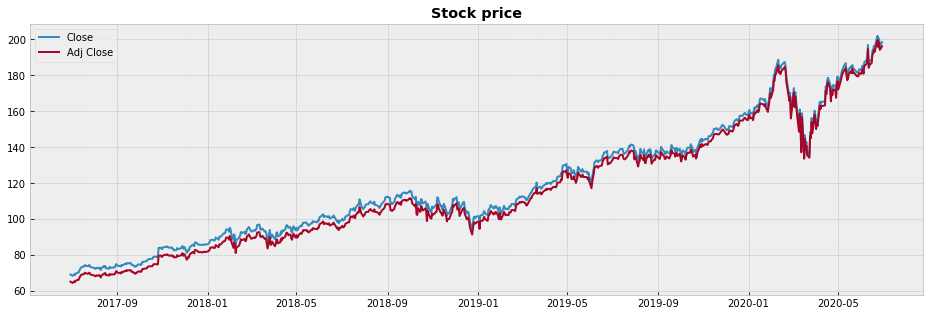

In [4]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

We convert datetime index to period

In [5]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')
price = prices['Adj Close']
dX = price.diff()

ret_log = np.log(price).diff()

ret = price.pct_change()

DatetimeIndex(['2017-06-30', '2017-07-03', '2017-07-05', '2017-07-06',
               '2017-07-07', '2017-07-10', '2017-07-11', '2017-07-12',
               '2017-07-13', '2017-07-14',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=754, freq=None)


We can calculate absolute difference in prices, logarithmic returns and arithmetic returns

In [6]:
ret = ret.dropna()

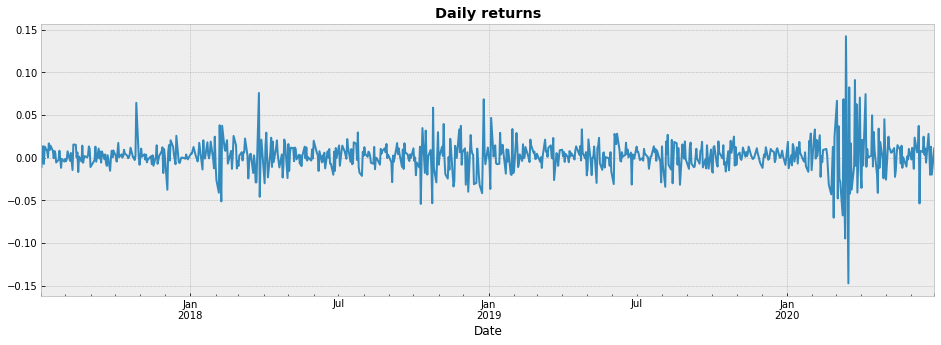

In [7]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

Расчёт VaR различными способами:

In [8]:
import scipy.stats as ss
alpha = 0.05

In [9]:
# This could also be accomodated to handle L_history of type pd.TimeDelta like '1 year'

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

### Extreme Value Theory


#### Block maxima and Generalized Extreme Value Distribution (GEV)

Resample losses with desired period (e.g. weekly)

In [10]:
maximas = ret.resample('W').min()
ret
maximas

Date
2017-07-03/2017-07-09   -0.011026
2017-07-10/2017-07-16    0.000143
2017-07-17/2017-07-23   -0.005794
2017-07-24/2017-07-30   -0.012019
2017-07-31/2017-08-06   -0.004655
                           ...   
2020-06-01/2020-06-07   -0.013164
2020-06-08/2020-06-14   -0.053698
2020-06-15/2020-06-21   -0.005960
2020-06-22/2020-06-28   -0.020158
2020-06-29/2020-07-05    0.010747
Freq: W-SUN, Name: Adj Close, Length: 157, dtype: float64

### GARCH models

#### GARCH with parametric distribution of residuals

In [11]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
# !pip install arch

In [12]:
from arch import arch_model

#### Wrapping into functions

1. GARCH model с постоянным средним, EGARCH(2, 1, 2) и skewed t-student распределением остатков (residuals)

   Пришлось использовать t-distribution, так как skewstudent не работало с EGARCH. Пробовал несколько комбинаций.
   https://imgur.com/a/ND7YiBi

In [13]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    dist = 't'
    am = arch_model(scaling_const * returns,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Egarch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [14]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceW

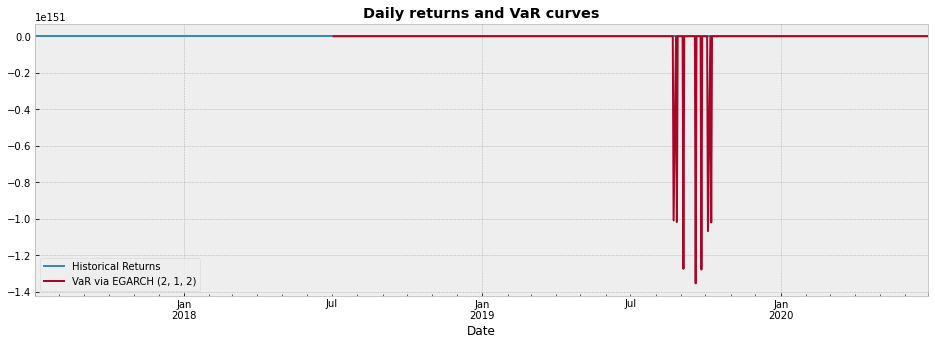

In [15]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
#VaR_HS.plot()
# VaR_t.plot()
VaR_garch.plot()
#VaR_FHS.plot()
#VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
           'VaR via EGARCH (2, 1, 2)',
           ])

plt.show()

 2. Обобщенное нормальное распределение

In [16]:
def calculate_VaR_gennorm(ret, alpha=0.05):

    beta, loc, scale = ss.gennorm.fit(ret)
    
    return ss.gennorm.ppf(alpha, beta, loc, scale)
VaR_gennorm = calc_VaR(ret, calculate_VaR_gennorm, L_history=252, level=alpha)

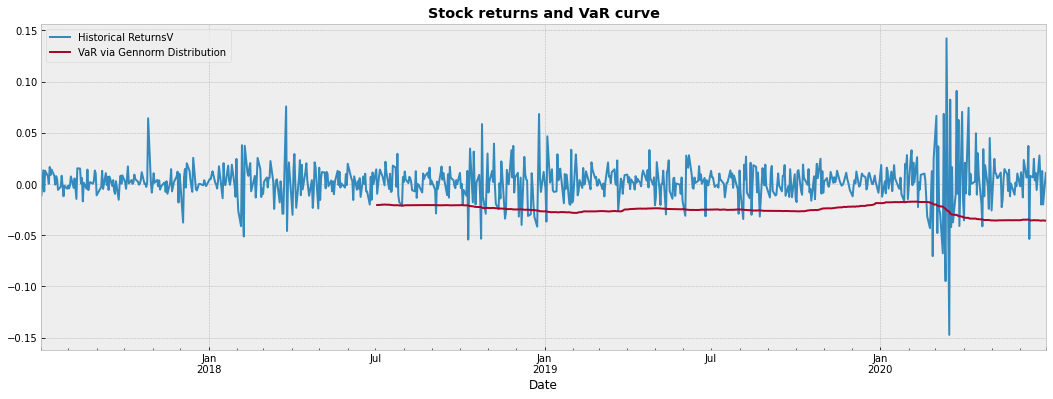

In [17]:
fig = plt.figure()
fig.set_size_inches(18,6)
ret.plot()
VaR_gennorm.plot()
plt.title("Stock returns and VaR curve", weight="bold")

plt.legend(['Historical ReturnsV',
           'VaR via Gennorm Distribution'])
plt.show()

3. Используйте комбинацию GARCH и EVT:

In [18]:
def calculate_VaR_FHS_with_EVT(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='Constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Harch', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='skewstudent')

    res = mdl.fit(disp='off')

   # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()
    
    
    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const
    u = conditional_sr.quantile(0.2)
    ret_tail = conditional_sr[conditional_sr <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    VaR_FHS = u - scale / c * ((alpha/(conditional_sr <= u).mean())**(-c) - 1)
    #return VaR_FHS

    # calculate VaR as quantile
    #VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [19]:
VaR_FHS_with_EVT = calc_VaR(ret, calculate_VaR_FHS_with_EVT, L_history=252, level=alpha)

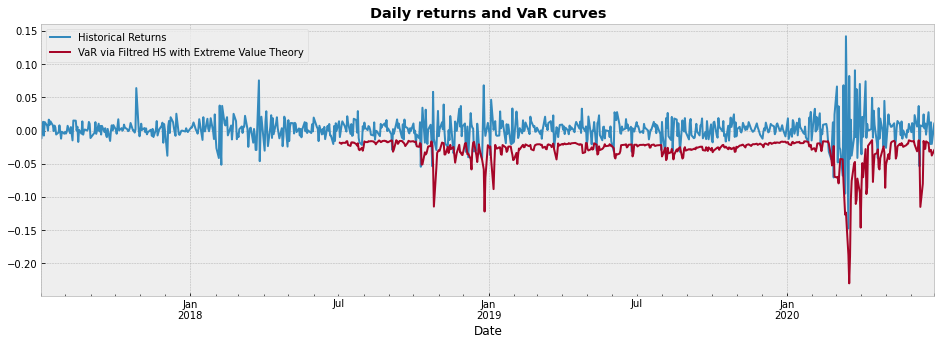

In [20]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_FHS_with_EVT.plot()

plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns',
            'VaR via Filtred HS with Extreme Value Theory'
            ])
plt.show()

4. На графике постройте все VaR кривые и проведите тесты, чтобы выбрать наиболее подходящий подход. График с ежедневными историческими доходностями и кривыми VaR:

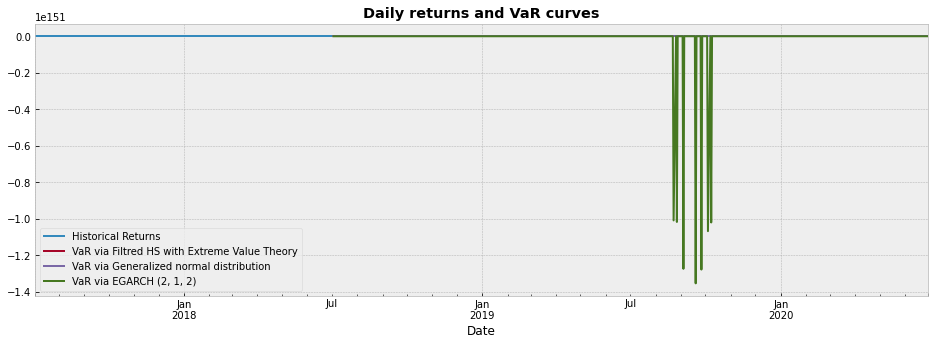

In [21]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_FHS_with_EVT.plot()
VaR_gennorm.plot()
VaR_garch.plot()
plt.title("Daily returns and VaR curves", weight="bold")
plt.legend(['Historical Returns',
            'VaR via Filtred HS with Extreme Value Theory',
            'VaR via Generalized normal distribution',
            'VaR via EGARCH (2, 1, 2)'
            ])
plt.show()

   5. p-value для каждой использованной модели

## Backtesting VaR

In [22]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [23]:
def calculate_VaR_t(ret, alpha=0.05):

    params_t = ss.t.fit(ret)
    
    return ss.t.ppf(alpha, *params_t)
VaR_t = calc_VaR(ret, calculate_VaR_t, L_history=252, level=alpha)

In [24]:
hits = calc_hits(ret, VaR_t)
hits

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False, False,  True,  True, False, False, False, False, False,
        True, False,

In [25]:
hits.mean()

0.08183632734530938

In [26]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [27]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [28]:
backtest_VaR(ret, VaR_garch, 1-alpha) #EGARCH (2, 1, 2)
backtest_VaR(ret, VaR_gennorm, 1-alpha) #Gennorm
backtest_VaR(ret, VaR_FHS_with_EVT, 1-alpha) #HARCH (2, 1, 2) + EVT

Backtesting calculate_VaR_garch:
The proportion of hits is 7.19% instead of expected 5.0%
Two-sided p-val 0.0307, one-sided: 0.0202
yellow zone

Backtesting calculate_VaR_gennorm:
The proportion of hits is 7.78% instead of expected 5.0%
Two-sided p-val 0.0073, one-sided: 0.00476
yellow zone

Backtesting calculate_VaR_FHS_with_EVT:
The proportion of hits is 5.39% instead of expected 5.0%
Two-sided p-val 0.681, one-sided: 0.373
green zone



6. Вывод:

Рекомендуется брать модель, находящуюся в зелёной зоне, с наибольшим значением p-value и наименьшим процентов просмотров. Выходит, необходимо выбрать модель номер 3 (GARCH + EVT), так как она демонстрирует лучшие показатели в ходе back-тестирования.